TP Groupe - Noé Duhamel, Guillaume Gatille & Nathan Stooss

In [277]:
import re
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from gensim.models.ldamodel import LdaModel

In [278]:
df_path = "bible.csv"
df = pd.read_csv(df_path)
print("Rows: " + format(df.shape[0]))
print("Columns: " + format(df.shape[1]))

Rows: 31103
Columns: 5


In [279]:
df.head()

,id,b,c,v,t
0,1001001,1,1,1,In the beginning God created the heaven and th...
1,1001002,1,1,2,"And the earth was without form, and void; and ..."
2,1001003,1,1,3,"And God said, Let there be light: and there wa..."
3,1001004,1,1,4,"And God saw the light, that it was good: and G..."
4,1001005,1,1,5,"And God called the light Day, and the darkness..."


Définissons la variable qui divisera l'ensemble des données en Nouveau et Ancien Testament.

In [280]:
df['t'] = df['t'].astype('str')
df.loc[df['b'] <= 39, 'testament'] = 'Old'
df.loc[df['b'] > 39, 'testament'] = 'New'
df

,id,b,c,v,t,testament
0,1001001,1,1,1,In the beginning God created the heaven and th...,Old
1,1001002,1,1,2,"And the earth was without form, and void; and ...",Old
2,1001003,1,1,3,"And God said, Let there be light: and there wa...",Old
3,1001004,1,1,4,"And God saw the light, that it was good: and G...",Old
4,1001005,1,1,5,"And God called the light Day, and the darkness...",Old
...,...,...,...,...,...,...
31098,66022017,66,22,17,"And the Spirit and the bride say, Come. And le...",New
31099,66022018,66,22,18,For I testify unto every man that heareth the ...,New
31100,66022019,66,22,19,And if any man shall take away from the words ...,New
31101,66022020,66,22,20,"He which testifieth these things saith, Surely...",New


In [281]:
# Stats descriptives sur le dataframe
df.rename(columns={
    'b': 'book_id', 
    'c': 'chapter_id',
    'v': 'verse_id',
    't': 'text'
    }, inplace=True)

df

,id,book_id,chapter_id,verse_id,text,testament
0,1001001,1,1,1,In the beginning God created the heaven and th...,Old
1,1001002,1,1,2,"And the earth was without form, and void; and ...",Old
2,1001003,1,1,3,"And God said, Let there be light: and there wa...",Old
3,1001004,1,1,4,"And God saw the light, that it was good: and G...",Old
4,1001005,1,1,5,"And God called the light Day, and the darkness...",Old
...,...,...,...,...,...,...
31098,66022017,66,22,17,"And the Spirit and the bride say, Come. And le...",New
31099,66022018,66,22,18,For I testify unto every man that heareth the ...,New
31100,66022019,66,22,19,And if any man shall take away from the words ...,New
31101,66022020,66,22,20,"He which testifieth these things saith, Surely...",New


## Nettoyage

In [282]:
# Obtention de la liste des stopwords à supprimer (plus performante que la librairie de NLTK par défaut)
words_to_delete = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", 
                   "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 
                   'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 
                   'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 
                   'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 
                   'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 
                   'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 
                   'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 
                   'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 
                   'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 
                   'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 
                   'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', 
                   "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 
                   'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
                    , 'unto', 'thou', 'thee', 'ye', 'him', 'upon', 'say', 'me', 'hath', 'also',"shouldn't", "wasn't", "weren't", 
                    "won't", "wouldn't", "unto", "thou", "thee", "ye", "him", "upon", "say", "me", "hath", "also", "ye"
                  ]

In [283]:
# Retirer les mots spécifiés du texte
df['text_cleaned'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in words_to_delete]))

# Retirer les chiffres
df['text_cleaned'] = df['text_cleaned'].str.replace(r'\d+', '')

# Retirer la ponctuation
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Retirer les espaces en trop
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Convertir text_cleaned en minuscule
df['text_cleaned'] = df['text_cleaned'].str.lower()

# Lemmatisation
lemmatizer = WordNetLemmatizer()
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Export en CSV pour éviter le retraitement sur des ordinateurs moins performants
df.to_csv('bible-cleaned.csv')

In [284]:
df.head()

,id,book_id,chapter_id,verse_id,text,testament,text_cleaned
0,1001001,1,1,1,In the beginning God created the heaven and th...,Old,beginning god created heaven earth
1,1001002,1,1,2,"And the earth was without form, and void; and ...",Old,earth without form void darkness face deep spi...
2,1001003,1,1,3,"And God said, Let there be light: and there wa...",Old,god said let light light
3,1001004,1,1,4,"And God saw the light, that it was good: and G...",Old,god saw light good god divided light darkness
4,1001005,1,1,5,"And God called the light Day, and the darkness...",Old,god called light day darkness called night eve...


In [285]:
# Test d'efficacité du nettoyage — Impression de la première ligne
# Cela permet de comparer les différentes étapes de nettoyage
print('Cleaned text: \n' + str(df['text'][0]))
print('Cleaned text: \n' + str(df['text_cleaned'][0]))

Cleaned text: 
In the beginning God created the heaven and the earth.
Cleaned text: 
beginning god created heaven earth


# Data Analysis

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31103 entries, 0 to 31102
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            31103 non-null  int64 
 1   book_id       31103 non-null  int64 
 2   chapter_id    31103 non-null  int64 
 3   verse_id      31103 non-null  int64 
 4   text          31103 non-null  object
 5   testament     31103 non-null  object
 6   text_cleaned  31103 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.7+ MB


In [287]:
columns_to_convert = ['id', 'book_id', 'chapter_id', 'verse_id']
df[columns_to_convert] = df[columns_to_convert].astype('int16')
print(df.dtypes)

id               int16
book_id          int16
chapter_id       int16
verse_id         int16
text            object
testament       object
text_cleaned    object
dtype: object


In [288]:
columns_to_convert = ['text', 'testament', 'text_cleaned']
df[columns_to_convert] = df[columns_to_convert].astype('string')
print(df.dtypes)



id                       int16
book_id                  int16
chapter_id               int16
verse_id                 int16
text            string[python]
testament       string[python]
text_cleaned    string[python]
dtype: object


In [289]:
# Ajout des colonnes contenant des stats descriptives
df['word_count'] = df['text_cleaned'].apply(lambda x: len(x.split()))
df['unique_word_count'] = df['text_cleaned'].apply(lambda x: len(set(x.split())))
df['sentence_count'] = df['text_cleaned'].apply(lambda x: len(sent_tokenize(x)))
df['avg_word_length'] = df['text_cleaned'].apply(lambda x: np.mean([len(word) for word in x.split()])).round(2)
df

c:\Users\guill\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


,id,book_id,chapter_id,verse_id,text,testament,text_cleaned,word_count,unique_word_count,sentence_count,avg_word_length
0,17961,1,1,1,In the beginning God created the heaven and th...,Old,beginning god created heaven earth,5,5,1,6.00
1,17962,1,1,2,"And the earth was without form, and void; and ...",Old,earth without form void darkness face deep spi...,12,11,1,4.92
2,17963,1,1,3,"And God said, Let there be light: and there wa...",Old,god said let light light,5,4,1,4.00
3,17964,1,1,4,"And God saw the light, that it was good: and G...",Old,god saw light good god divided light darkness,8,6,1,4.75
4,17965,1,1,5,"And God called the light Day, and the darkness...",Old,god called light day darkness called night eve...,11,9,1,5.27
...,...,...,...,...,...,...,...,...,...,...,...
31098,27265,66,22,17,"And the Spirit and the bride say, Come. And le...",New,spirit bride say come let heareth say come let...,18,13,1,4.67
31099,27266,66,22,18,For I testify unto every man that heareth the ...,New,testify every man heareth word prophecy book m...,17,13,1,4.82
31100,27267,66,22,19,And if any man shall take away from the words ...,New,man shall take away word book prophecy god sha...,19,14,1,4.42
31101,27268,66,22,20,"He which testifieth these things saith, Surely...",New,testifieth thing saith surely come quickly ame...,12,11,1,5.00


Avec cet ensemble de données donné, on peux appliquer une analyse complète. Tout d'abord, on commence par un sujet intéressant : comment la longueur des versets évolue à travers les livres de la Bible. 
Pourquoi cette information peut-elle être utile ? Elle nous permet d'estimer approximativement quand les livres ont été écrits et la longueur des versets offre beaucoup de connaissances sur la culture à ce moment.

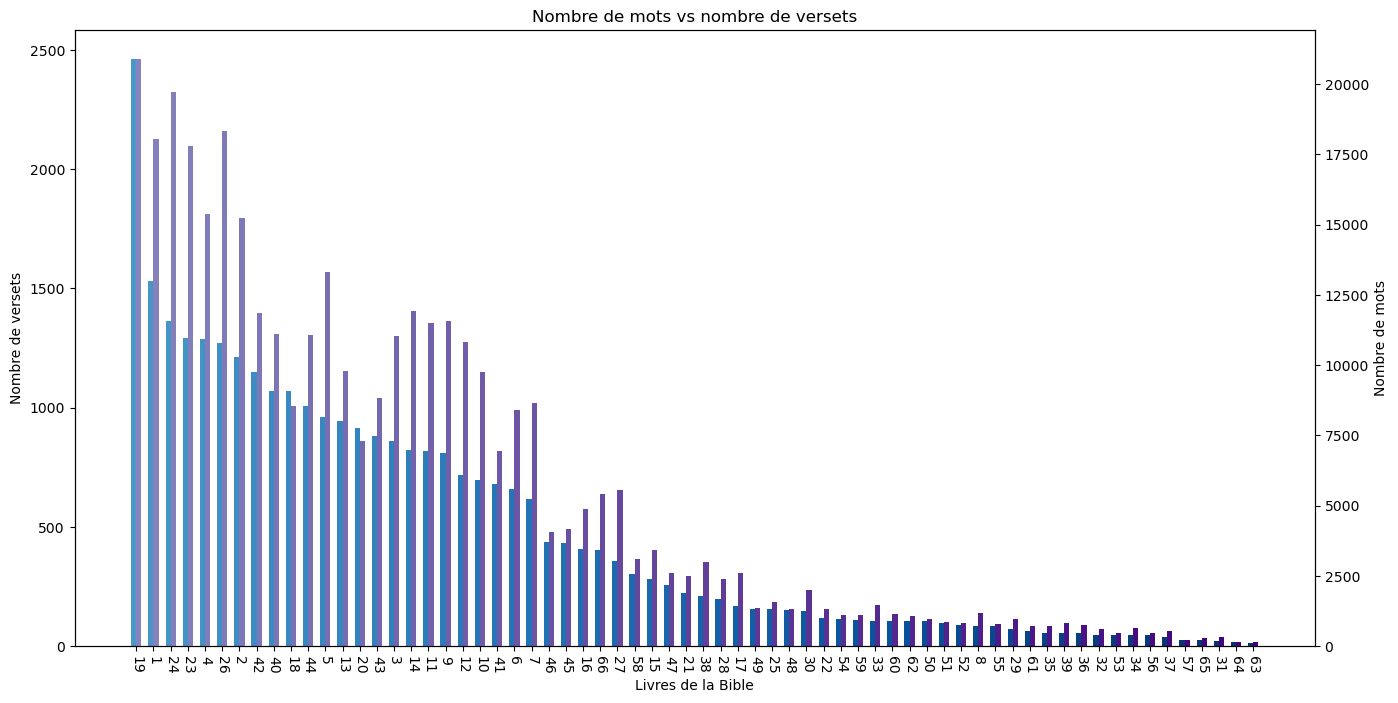

In [290]:
verses_column = 'verse_id'
words_column = 'word_count'

# Ajout de couleur
color_1 = plt.cm.Blues(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, 66))

# Regroupement par 'book_id' représentant les livres de la Bible.
words_verses = df.groupby('book_id').agg({verses_column: 'count', words_column: 'sum'}).sort_values(by=verses_column, ascending=False)
data1 = words_verses[verses_column]
data2 = words_verses[words_column]

plt.figure(figsize=(16, 8))
x = np.arange(66)
ax1 = plt.subplot(1, 1, 1)
w = 0.3

color = color_1
plt.title('Nombre de mots vs nombre de versets')
plt.xticks(x + w / 2, data1.index, rotation=-90)
ax1.set_xlabel('Livres de la Bible')
ax1.set_ylabel('Nombre de versets')
ax1.bar(x, data1.values, color=color_1, width=w, align='center')

ax2 = ax1.twinx()

color = color_2
ax2.set_ylabel('Nombre de mots')
ax2.bar(x + w, data2, color=color_2, width=w, align='center')

plt.show()


En visualisant l'évolution du nombre total de mots par livre, on peux  obtenir des informations sur la longueur relative des livres. Certains livres peuvent être plus longs que d'autres, ce qui peut refléter la complexité de leur contenu.

In [291]:
# # Calcul du nombre total de mots par livre
# total_words_by_book = df.groupby('book_id')['word_count'].sum().reset_index()

# # Plotting
# plt.figure(figsize=(15, 6))
# sns.lineplot(x='book_id', y='word_count', data=total_words_by_book, marker='o', color='green')
# plt.title('Evolution of the Number of Words in Books')
# plt.xlabel('Book ID')
# plt.ylabel('Total Word Count')
# plt.show()

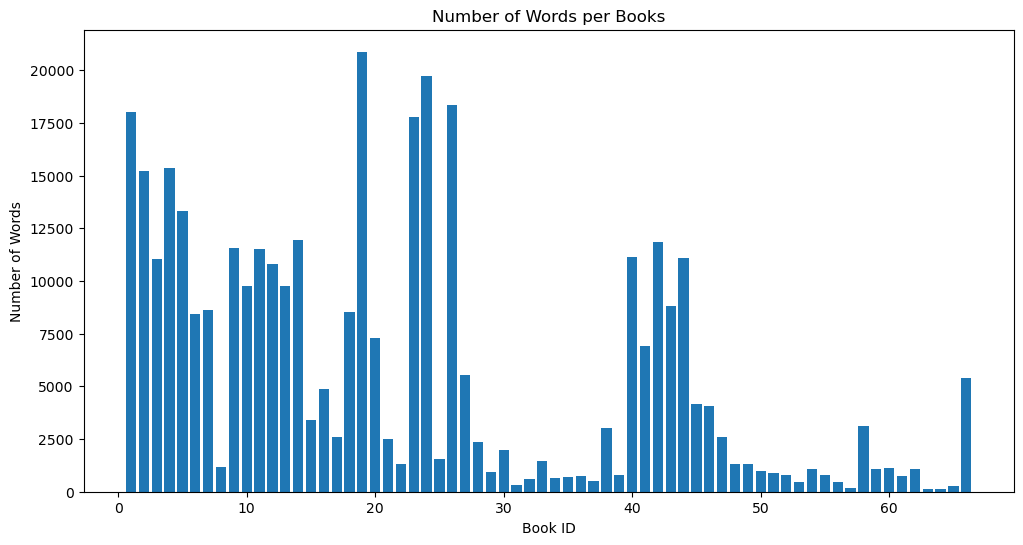

In [292]:
# Group the dataframe by book_id and calculate the sum of occurrences for each word
verses_counts = df.groupby('book_id')['verse_id'].count()
words_counts = df.groupby('book_id')['word_count'].sum()

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(verses_counts.index, words_counts, width=0.8)
plt.xlabel('Book ID')
plt.ylabel('Number of Words')
plt.title('Number of Words per Books')
plt.show()

En analysant graphiquement les données, on peut rapidement identifier les livres où les références à "God" et "Jesus" sont plus fréquentes, ainsi que les tendances générales au fil des différents IDs de livre. Ici Jésus apparait dans le New testament logiquement.

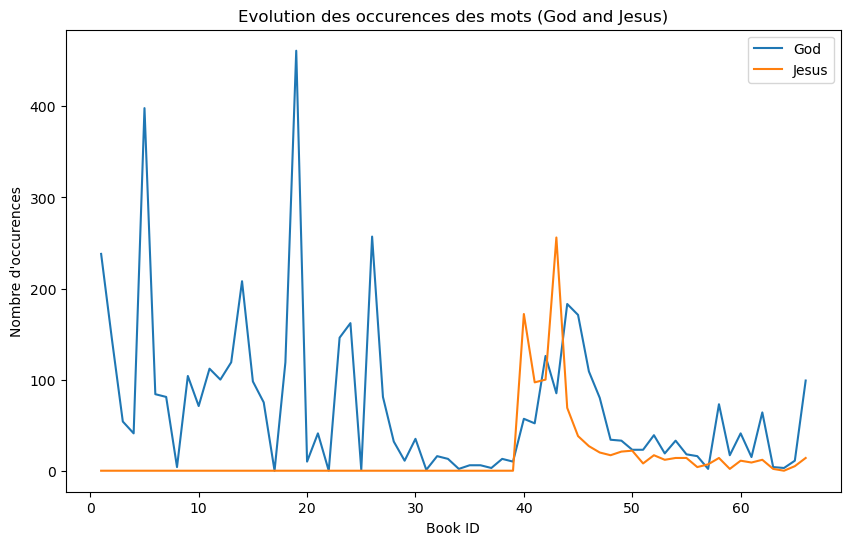

In [293]:
# Regroupement des données par numéro de livre et calcul de la somme des occurrences pour chaque mot
god_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('god').sum())
jesus_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('jesus').sum())

# Création d'un graphique
plt.figure(figsize=(10, 6))
plt.plot(god_counts.index, god_counts.values, label='God')
plt.plot(jesus_counts.index, jesus_counts.values, label='Jesus')
plt.xlabel('Book ID')
plt.ylabel('Nombre d\'occurences')
plt.title('Evolution des occurences des mots (God and Jesus)')
plt.legend()
plt.show()

Ce graphique facilite  l'identification de tendances générales dans l'utilisation de ces termes clés lié au pouvoir et facilitant ainsi une analyse thématique eventuel.

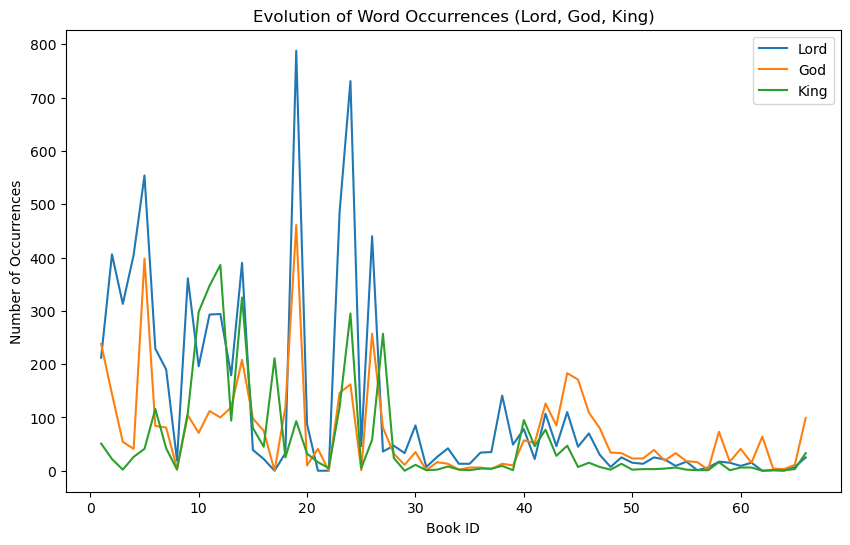

In [294]:
# Regroupement des données par numéro de livre et calcul de la somme des occurrences pour chaque mot
lord_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('lord').sum())
god_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('god').sum())
king_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('king').sum())

# Création d'un graphique
plt.figure(figsize=(10, 6))
plt.plot(lord_counts.index, lord_counts.values, label='Lord')
plt.plot(god_counts.index, god_counts.values, label='God')
plt.plot(king_counts.index, king_counts.values, label='King')
plt.xlabel('Book ID')
plt.ylabel('Number of Occurrences')
plt.title('Evolution of Word Occurrences (Lord, God, King)')
plt.legend()
plt.show()


La représentation graphique des termes "Holy," "Son," et "Father" dans l'Ancien Testament et le NOUVEAU est utile car elle offre une vision  des thèmes théologiques ET permet une compréhension  rapide du vocabulaire utilisé.

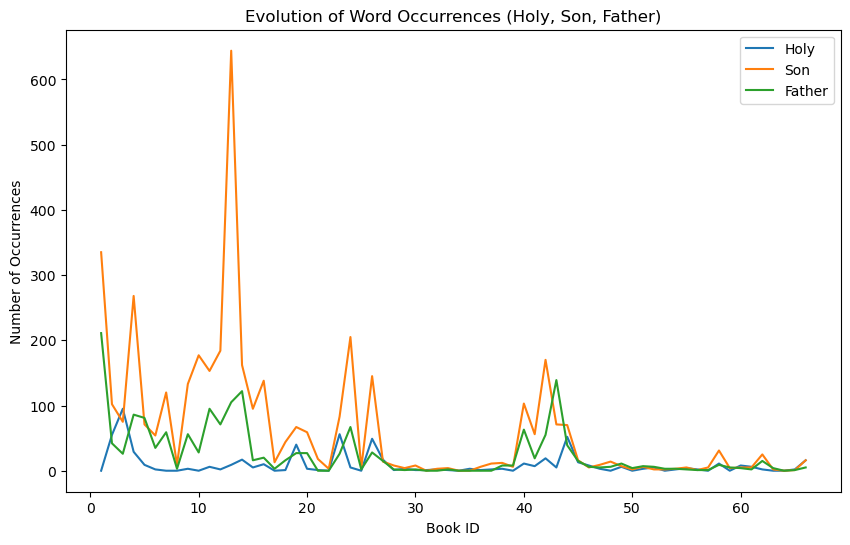

In [295]:
# Group the dataframe by book_id and calculate the sum of occurrences for each word
holy_spirit_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('holy').sum())
son_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('son').sum())
father_counts = df.groupby('book_id')['text_cleaned'].apply(lambda x: x.explode().str.count('father').sum())

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(holy_spirit_counts.index, holy_spirit_counts.values, label='Holy')
plt.plot(son_counts.index, son_counts.values, label='Son')
plt.plot(father_counts.index, father_counts.values, label='Father')
plt.xlabel('Book ID')
plt.ylabel('Number of Occurrences')
plt.title('Evolution of Word Occurrences (Holy, Son, Father)')
plt.legend()
plt.show()

Visualisation en nuage de mots de ceux les plus utilisés entre ancien et nouveau testament

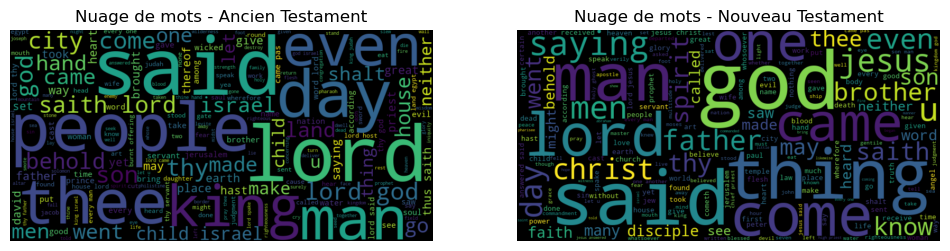

In [296]:
# Filtrage la base de données pour obtenir le texte de l'Ancien Testament
old_testament_text = ' '.join(df[df['testament'] == 'Old']['text_cleaned'])

# Générer un nuage de mots pour l'Ancien Testament
wordcloud_old = WordCloud(width=800, height=400, max_font_size=150).generate(old_testament_text)

# Filtrer le dataframe pour obtenir le texte du Nouveau Testament
new_testament_text = ' '.join(df[df['testament'] == 'New']['text_cleaned'])

# Générer un nuage de mots pour le Nouveau Testament
wordcloud_new = WordCloud(width=800, height=400, max_font_size=150).generate(new_testament_text)

# Plot the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_old, interpolation='bilinear')
plt.title('Nuage de mots - Ancien Testament')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_new, interpolation='bilinear')
plt.title('Nuage de mots - Nouveau Testament')
plt.axis('off')

plt.show()



## N-gramm / Bi-gramm / Tri-gramm

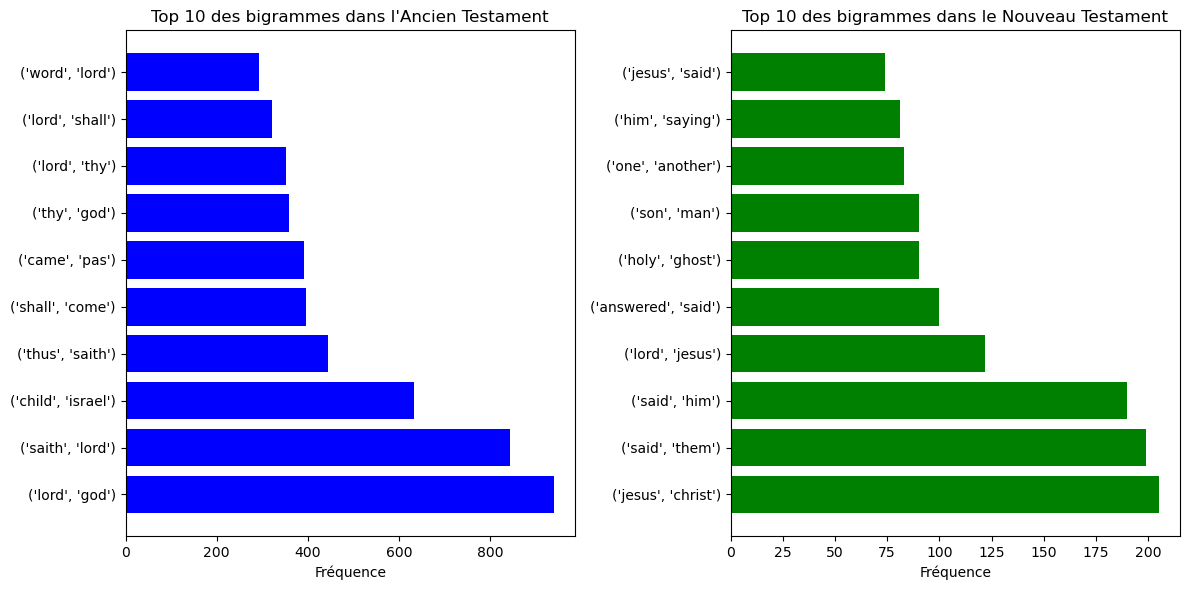

In [297]:
# Fonction pour obtenir les n-grammes les plus fréquents
def get_most_frequent_ngrams(text, n, top_k):
    # Tokeniser le texte en mots
    words = text.split()
    
    # Générer les n-grammes
    ngrams_list = list(ngrams(words, n))
    
    # Compter la fréquence de chaque n-gramme
    ngrams_freq = Counter(ngrams_list)
    
    # Obtenir les k n-grammes les plus fréquents
    top_ngrams = ngrams_freq.most_common(top_k)
    
    return top_ngrams

# Obtenir les bigrammes les plus fréquents dans l'Ancien Testament
old_testament_bigrams = get_most_frequent_ngrams(old_testament_text, 2, 10)

# Obtenir les bigrammes les plus fréquents dans le Nouveau Testament
new_testament_bigrams = get_most_frequent_ngrams(new_testament_text, 2, 10)

# Tracer les graphiques à barres pour les bigrammes de l'Ancien et du Nouveau Testament
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bigrammes de l'Ancien Testament
axes[0].barh([str(bigram) for bigram, frequency in old_testament_bigrams], [frequency for bigram, frequency in old_testament_bigrams], color='blue')
axes[0].set_title('Top 10 des bigrammes dans l\'Ancien Testament')
axes[0].set_xlabel('Fréquence')

# Bigrammes du Nouveau Testament
axes[1].barh([str(bigram) for bigram, frequency in new_testament_bigrams], [frequency for bigram, frequency in new_testament_bigrams], color='green')
axes[1].set_title('Top 10 des bigrammes dans le Nouveau Testament')
axes[1].set_xlabel('Fréquence')

plt.tight_layout()
plt.show()


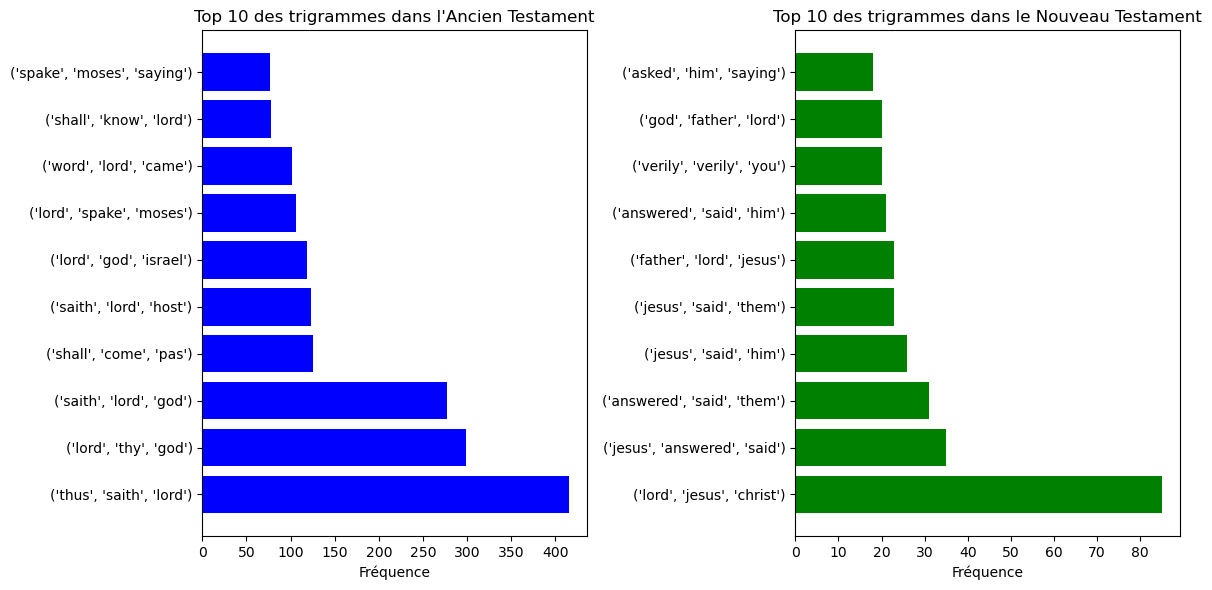

In [298]:
# Fonction pour obtenir les n-grammes les plus fréquents
def get_most_frequent_ngrams(text, n, top_k):
    # Tokeniser le texte en mots
    words = text.split()
    
    # Générer les n-grammes
    ngrams_list = list(ngrams(words, n))
    
    # Compter la fréquence de chaque n-gramme
    ngrams_freq = Counter(ngrams_list)
    
    # Obtenir les k n-grammes les plus fréquents
    top_ngrams = ngrams_freq.most_common(top_k)
    
    return top_ngrams

# Obtenir les trigrammes les plus fréquents dans l'Ancien Testament
old_testament_trigrams = get_most_frequent_ngrams(old_testament_text, 3, 10)

# Obtenir les trigrammes les plus fréquents dans le Nouveau Testament
new_testament_trigrams = get_most_frequent_ngrams(new_testament_text, 3, 10)

# Trier les trigrammes par fréquence en ordre décroissant
old_testament_trigrams.sort(key=lambda x: x[1], reverse=True)
new_testament_trigrams.sort(key=lambda x: x[1], reverse=True)

# Tracer les graphiques à barres pour les trigrammes de l'Ancien et du Nouveau Testament
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Trigrammes de l'Ancien Testament
axes[0].barh([str(trigram) for trigram, frequency in old_testament_trigrams], [frequency for trigram, frequency in old_testament_trigrams], color='blue')
axes[0].set_title('Top 10 des trigrammes dans l\'Ancien Testament')
axes[0].set_xlabel('Fréquence')

# Trigrammes du Nouveau Testament
axes[1].barh([str(trigram) for trigram, frequency in new_testament_trigrams], [frequency for trigram, frequency in new_testament_trigrams], color='green')
axes[1].set_title('Top 10 des trigrammes dans le Nouveau Testament')
axes[1].set_xlabel('Fréquence')

plt.tight_layout()
plt.show()


## BOW - Corpus

In [299]:
# Utilisation de CountVectorizer pour obtenir les caractéristiques du BOW
cv = CountVectorizer()
cv_matrix = cv.fit_transform(df['text_cleaned'])

# Mots uniques dans le corpus
vocab = cv.get_feature_names_out()

# Affichage des vecteurs de caractéristiques des documents dans un DataFrame
bible_df_feature_vectors = pd.DataFrame(cv_matrix.toarray(), columns=vocab)

# Affichage du DataFrame
bible_df_feature_vectors

,aaron,aaronites,abaddon,abagtha,abana,abarim,abase,abased,abasing,abated,...,zorathites,zoreah,zorites,zorobabel,zuar,zuph,zur,zuriel,zurishaddai,zuzims
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31098,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF

In [300]:
# Aggrégation des versets par livre pour effecter une analyse par livre

books = {}
for verse in range(len(df)):
    current_book = df['book_id'].iloc[verse]
    if(current_book in books):
        books[current_book] = str(books[current_book]) + str(df['text_cleaned'].iloc[verse]) + ' '
    else: 
        books[current_book] = str(df['text_cleaned'].iloc[verse]) + ' '

books_list = list(books.values())
books_df = pd.DataFrame(books_list, columns=['corpus'])

del books_list

In [301]:
# Création d'un objet TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit du TfidfVectorizer sur la colonne 'text_cleaned' des livres échantillonnés
tfidf_matrix = tfidf_vectorizer.fit_transform(books_df['corpus'])

# Vocabulaire
vocab = tfidf_vectorizer.get_feature_names_out()

# Création d'une liste pour stocker les 3 principaux termes TF-IDF pour chaque livre
top_tfidf_terms_list = []

# Pour chaque livre échantillonné, obtention des  3 principaux termes TF-IDF
for idx, book in enumerate(books_df['corpus']):
    tfidf_scores = tfidf_matrix[idx, :].toarray().flatten()
    
    # Création d'un dictionnaire pour stocker le terme et son score TF-IDF
    tfidf_dict = {term: round(score, 2) for term, score in zip(vocab, tfidf_scores)}
    
    # Tri des termes par score TF-IDF, et obtention des trois premiers
    sorted_tfidf_terms = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:3]
    
    # Ajout des résultats à la liste
    top_tfidf_terms_list.append({'Book': idx, 'Top 3 Terms': sorted_tfidf_terms})

# Création d'un DataFrame à partir de la liste
top_tfidf_terms_df = pd.DataFrame(top_tfidf_terms_list)

print(top_tfidf_terms_df)


    Book                                       Top 3 Terms
0      0          [(said, 0.36), (jacob, 0.2), (son, 0.2)]
1      1      [(moses, 0.33), (shall, 0.33), (lord, 0.29)]
2      2   [(shall, 0.65), (offering, 0.32), (lord, 0.22)]
3      3   [(shall, 0.38), (offering, 0.28), (lord, 0.27)]
4      4         [(thy, 0.49), (lord, 0.4), (shall, 0.34)]
..   ...                                               ...
61    61        [(god, 0.42), (love, 0.27), (world, 0.25)]
62    62     [(christ, 0.27), (lady, 0.26), (truth, 0.24)]
63    63     [(truth, 0.29), (church, 0.24), (doeth, 0.2)]
64    64  [(ungodly, 0.37), (christ, 0.21), (jesus, 0.21)]
65    65       [(angel, 0.26), (earth, 0.21), (god, 0.21)]

[66 rows x 2 columns]


# LDA 

Le dictionnaire est un mappage entre les mots et leurs identifiants entiers,
Le corpus est une liste de documents représentés sous forme d'un BoW.

In [303]:
documents = df["text_cleaned"].apply(lambda x: x.split(' '))

# Création d'un dictionnaire
id2word = corpora.Dictionary(documents)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in documents]

In [305]:
# Initialisation des variables pour le meilleur modèle
best_coherence = -1
best_lda_model = None
best_num_topics = 0

# Esssai de différents nombres de topics
for num_topics in range(3, 10):
    # Construction du modèle LDA
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, alpha="auto", per_word_topics=True)

    # Calcul du score de cohérence
    coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=id2word, coherence="c_v")
    coherence_lda = coherence_model_lda.get_coherence()

    # Pour chaque nombre de topic, affichage du score de cohérence lié
    print(f"Nombre de topics: {num_topics}, score de cohérence: {coherence_lda}")

    # Stockage et mise à jour du meilleur modèle, si ce dernier est plus cohérent
    if coherence_lda > best_coherence:
        best_coherence = coherence_lda
        best_lda_model = lda_model
        best_num_topics = num_topics


Nombre de topics: 3, score de cohérence: 0.3303072044228425
Nombre de topics: 4, score de cohérence: 0.3236695272447764
Nombre de topics: 5, score de cohérence: 0.2960514728911128
Nombre de topics: 6, score de cohérence: 0.31770514020097546
Nombre de topics: 7, score de cohérence: 0.34819734958522863
Nombre de topics: 8, score de cohérence: 0.3267167525182785
Nombre de topics: 9, score de cohérence: 0.34480267760284744


In [306]:
# Affichage du meilleur nombre de topics
print(f"\nBest Number of Topics: {best_num_topics}")

# Imprimer les mots-clés pour chaque sujet dans le meilleur modèle
pprint(best_lda_model.print_topics())


Best Number of Topics: 7
[(0,
  '0.046*"thy" + 0.022*"world" + 0.014*"shall" + 0.011*"hast" + '
  '0.010*"kingdom" + 0.010*"all" + 0.010*"thee" + 0.010*"throne" + '
  '0.010*"shalt" + 0.009*"lord"'),
 (1,
  '0.022*"prophet" + 0.018*"body" + 0.017*"lord" + 0.016*"receive" + '
  '0.016*"one" + 0.015*"received" + 0.014*"year" + 0.013*"seven" + '
  '0.012*"truth" + 0.012*"priest"'),
 (2,
  '0.020*"shall" + 0.018*"jew" + 0.017*"city" + 0.013*"sea" + 0.011*"gentile" '
  '+ 0.011*"land" + 0.010*"great" + 0.008*"them" + 0.007*"went" + '
  '0.007*"praise"'),
 (3,
  '0.046*"shall" + 0.036*"god" + 0.025*"lord" + 0.017*"thing" + 0.015*"you" + '
  '0.013*"man" + 0.011*"saith" + 0.011*"me" + 0.011*"them" + 0.011*"come"'),
 (4,
  '0.012*"one" + 0.011*"man" + 0.010*"lord" + 0.010*"behold" + 0.009*"part" + '
  '0.009*"believe" + 0.009*"shall" + 0.008*"house" + 0.008*"temple" + '
  '0.008*"eye"'),
 (5,
  '0.031*"him" + 0.028*"christ" + 0.027*"jesus" + 0.023*"said" + 0.021*"son" + '
  '0.021*"came" + 0.

Nous avons décidé de calculer la cohérence pour différents nombres de sujets et à choisir le modèle qui donne la cohérence la plus élevée. Ici 3 est indiqué comme le meilleur nombres de Topics.

In [307]:
# Afficher la visualisation du meilleur modèle
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda_model, corpus, id2word)
pyLDAvis.display(vis)

# Clustering

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_cleaned'])

In [ ]:
pca = PCA(n_components=2)
reduced_tfidf = pca.fit_transform(tfidf_matrix.toarray())
reduced_tfidf.shape

(31103, 2)

In [ ]:
scores = []  # ici on va stocker les scores
cluster_range = range(1, 10)  # et ici le nombre de clusters que l'on veut tester (de 1 à 10)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=100)
    kmeans.fit(reduced_tfidf)
    scores.append(kmeans.inertia_)

c:\Users\guill\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\guill\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\guill\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\guill\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

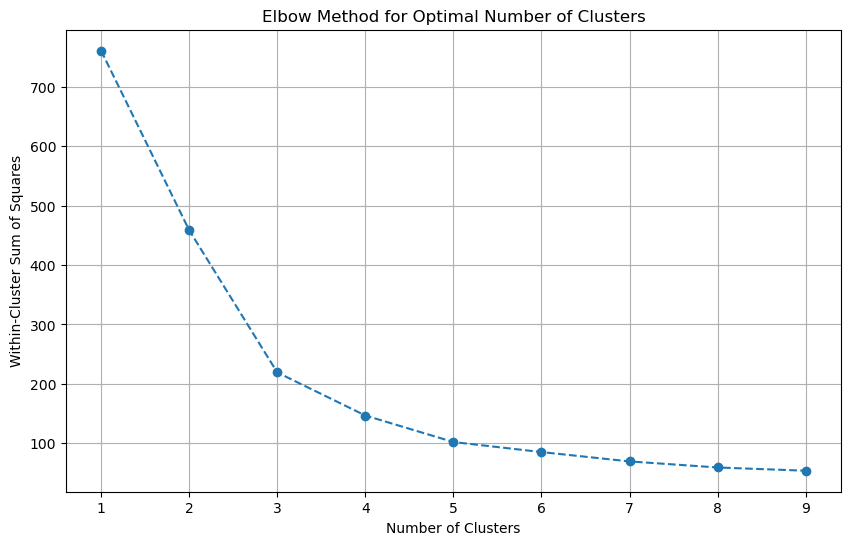

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

In [ ]:
optimal_k = 3  # Replace 3 with the actual optimal number of clusters

kmeans = KMeans(n_clusters=optimal_k, random_state=100)
clusters = kmeans.fit_predict(reduced_tfidf)

c:\Users\guill\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


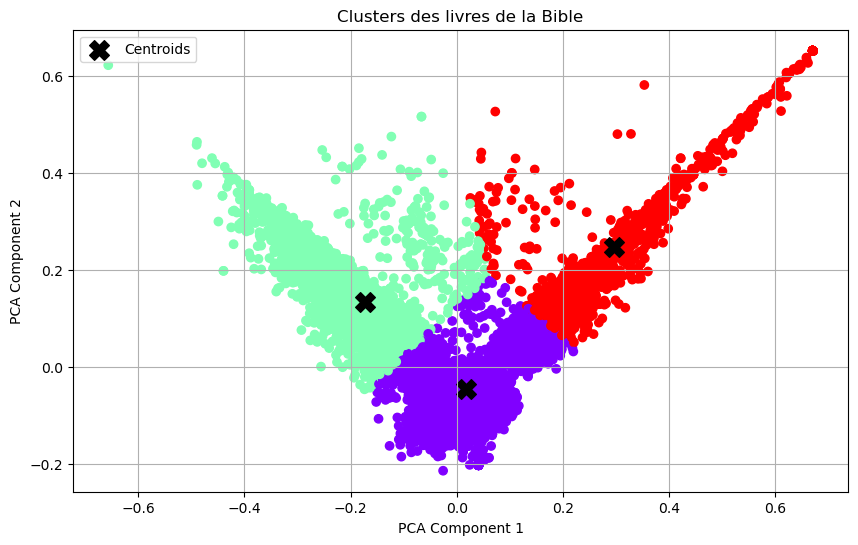

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(reduced_tfidf[:, 0], reduced_tfidf[:, 1], c=clusters, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='X', label='Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters des livres de la Bible')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Vérification de la répartition par cluster
X_train = df['text']
y_km = kmeans.fit_predict(reduced_tfidf)
df_km = pd.DataFrame({'statements' :X_train, 'topic_cluster' :y_km })
df_km.groupby('topic_cluster').count()

c:\Users\guill\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,statements
topic_cluster,
0,24274
1,5253
2,1576


# Sentiment Analysis avec NLTK

In [ ]:
df

,id,book_id,chapter_id,verse_id,text,testament,text_cleaned,word_count,unique_word_count,sentence_count,avg_word_length
0,17961,1,1,1,In the beginning God created the heaven and th...,Old,beginning god created heaven earth,5,5,1,6.00
1,17962,1,1,2,"And the earth was without form, and void; and ...",Old,earth without form void darkness face deep spi...,12,11,1,4.92
2,17963,1,1,3,"And God said, Let there be light: and there wa...",Old,god said let light light,5,4,1,4.00
3,17964,1,1,4,"And God saw the light, that it was good: and G...",Old,god saw light good god divided light darkness,8,6,1,4.75
4,17965,1,1,5,"And God called the light Day, and the darkness...",Old,god called light day darkness called night eve...,11,9,1,5.27
...,...,...,...,...,...,...,...,...,...,...,...
31098,27265,66,22,17,"And the Spirit and the bride say, Come. And le...",New,spirit bride say come let heareth say come let...,18,13,1,4.67
31099,27266,66,22,18,For I testify unto every man that heareth the ...,New,testify every man heareth word prophecy book m...,17,13,1,4.82
31100,27267,66,22,19,And if any man shall take away from the words ...,New,man shall take away word book prophecy god sha...,19,14,1,4.42
31101,27268,66,22,20,"He which testifieth these things saith, Surely...",New,testifieth thing saith surely come quickly ame...,12,11,1,5.00


In [ ]:
# Initialiser l'analyseur d'intensité des sentiments
sia = SentimentIntensityAnalyzer()

# Définir une fonction pour calculer le score de sentiment pour un verset donné
def get_sentiment_score(verse):
    # Calculate sentiment score
    sentiment_score = sia.polarity_scores(verse)['compound']
    return sentiment_score

# Apply the sentiment analysis function to the 'text_cleaned' column in your DataFrame
df['sentiment_score'] = df['text_cleaned'].apply(get_sentiment_score)

# Categorize sentiment based on the sentiment score
df['sentiment'] = df['sentiment_score'].apply(lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral')

df[['text_cleaned', 'sentiment_score', 'sentiment']]

,text_cleaned,sentiment_score,sentiment
0,beginning god created heaven earth,0.7506,positive
1,earth without form void darkness face deep spi...,0.5484,positive
2,god said let light light,0.2732,positive
3,god saw light good god divided light darkness,0.6249,positive
4,god called light day darkness called night eve...,0.0258,positive
...,...,...,...
31098,spirit bride say come let heareth say come let...,0.5574,positive
31099,testify every man heareth word prophecy book m...,0.2732,positive
31100,man shall take away word book prophecy god sha...,0.2732,positive
31101,testifieth thing saith surely come quickly ame...,0.4404,positive


<Axes: xlabel='book_id'>

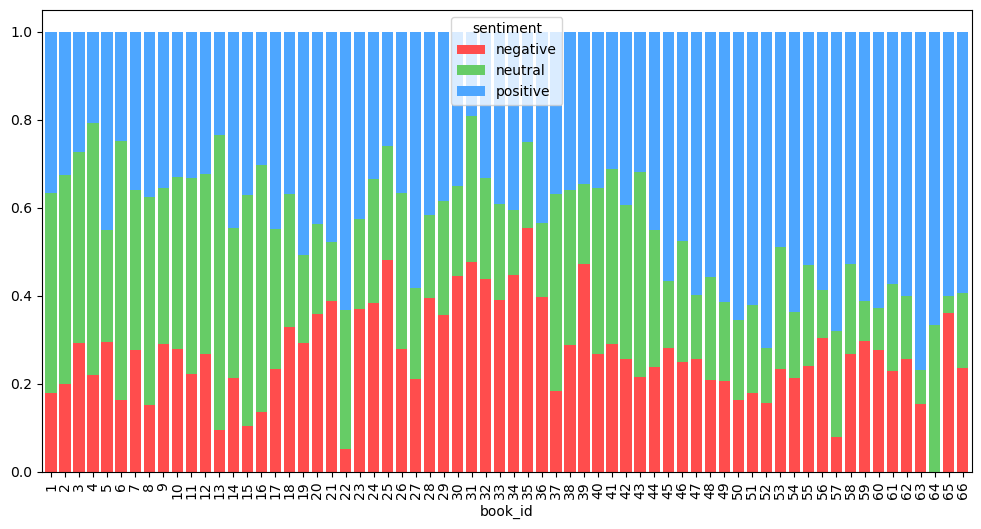

In [ ]:
# Regrouper les données par book_id et sentiment
grouped_data = df.groupby(['book_id', 'sentiment']).size().unstack()

# Calculer la proportion de chaque sentiment par book_id
proportional_data = grouped_data.div(grouped_data.sum(axis=1), axis=0)
proportional_data.plot(figsize=(12, 6), kind='bar', stacked=True, width=0.8, color=['#FF4D4D', '#66CC66', '#4DA6FF'])